# Quantum NLP Challenge

In [1]:
%pdb 0

Automatic pdb calling has been turned OFF


In [2]:
%matpotlib inline

UsageError: Line magic function `%matpotlib` not found.


In [3]:
import sys

In [4]:
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scikit-learn

## Data

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk

RANDOM_SEED = 220811
np.random.seed(RANDOM_SEED)

In [12]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [11]:
from lambeq import BobcatParser, DepCCGParser
from discopy import grammar

/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [13]:
from lambeq import Rewriter

In [40]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

In [48]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

In [6]:
df = pd.read_csv("MC1.TXT", header=None, sep=", ", engine="python")

In [7]:
df.columns = ["s1", "s2", "label"]

In [8]:
df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


In [9]:
vocab = set()
lengths = set()

for i, r in df.iterrows():
    tokens = r.s1.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]
    tokens = r.s2.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]

In [10]:
print(vocab, len(vocab), max(lengths))

{'prepares', 'advanced', 'devoted', 'hacker', 'experienced', 'chef', 'tasty', 'writes', 'skilful', 'code', 'meal', 'cook', 'complicated', 'dish', 'creates', 'programmer'} 16 5


## Lambeq tutorial

### Sentence input

In [10]:
sentence = "John walks in the park"

In [11]:
parser = BobcatParser()
diagram = parser.sentence2diagram(sentence)

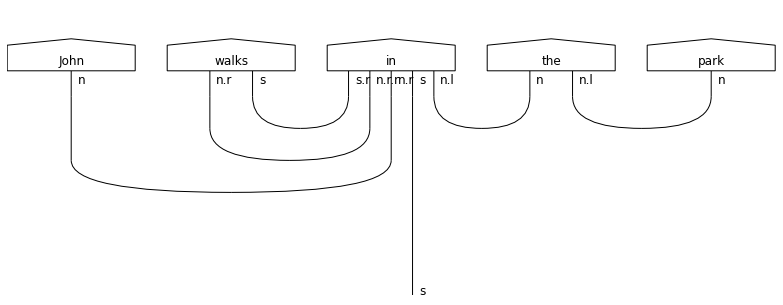

In [12]:
grammar.draw(diagram, figsize=(16, 4), fontsize=12)

### Diagram rewriting

In [14]:
# Prepositional phrase rewrite rule
rewriter = Rewriter(["prepositional_phrase", "determiner"])
rewritten_diagram = rewriter(diagram)

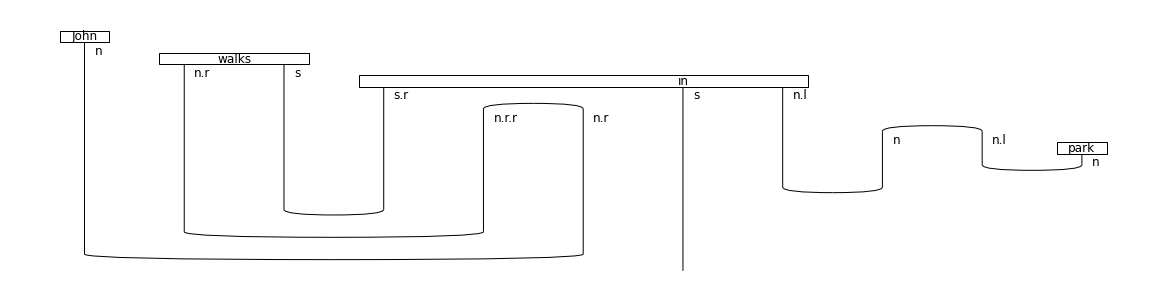

In [15]:
rewritten_diagram.draw(figsize=(16, 4), fontsize=12)

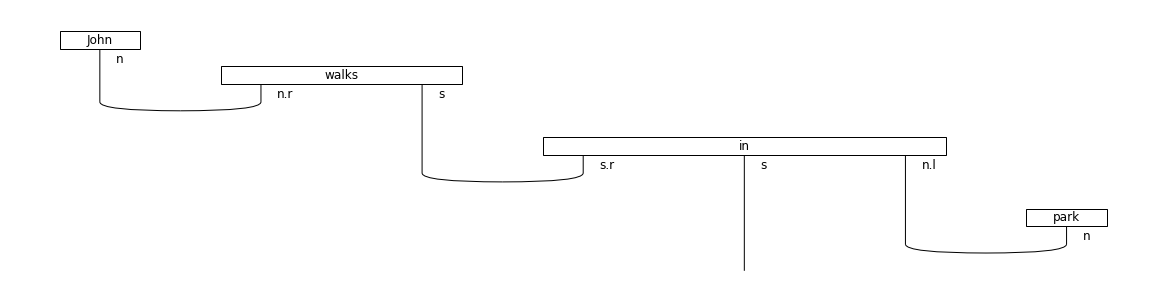

In [16]:
# Normalize
normalized_diagram = rewritten_diagram.normal_form()
normalized_diagram.draw(figsize=(16, 4), fontsize=12)

### Parametrization

In [18]:
# Atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

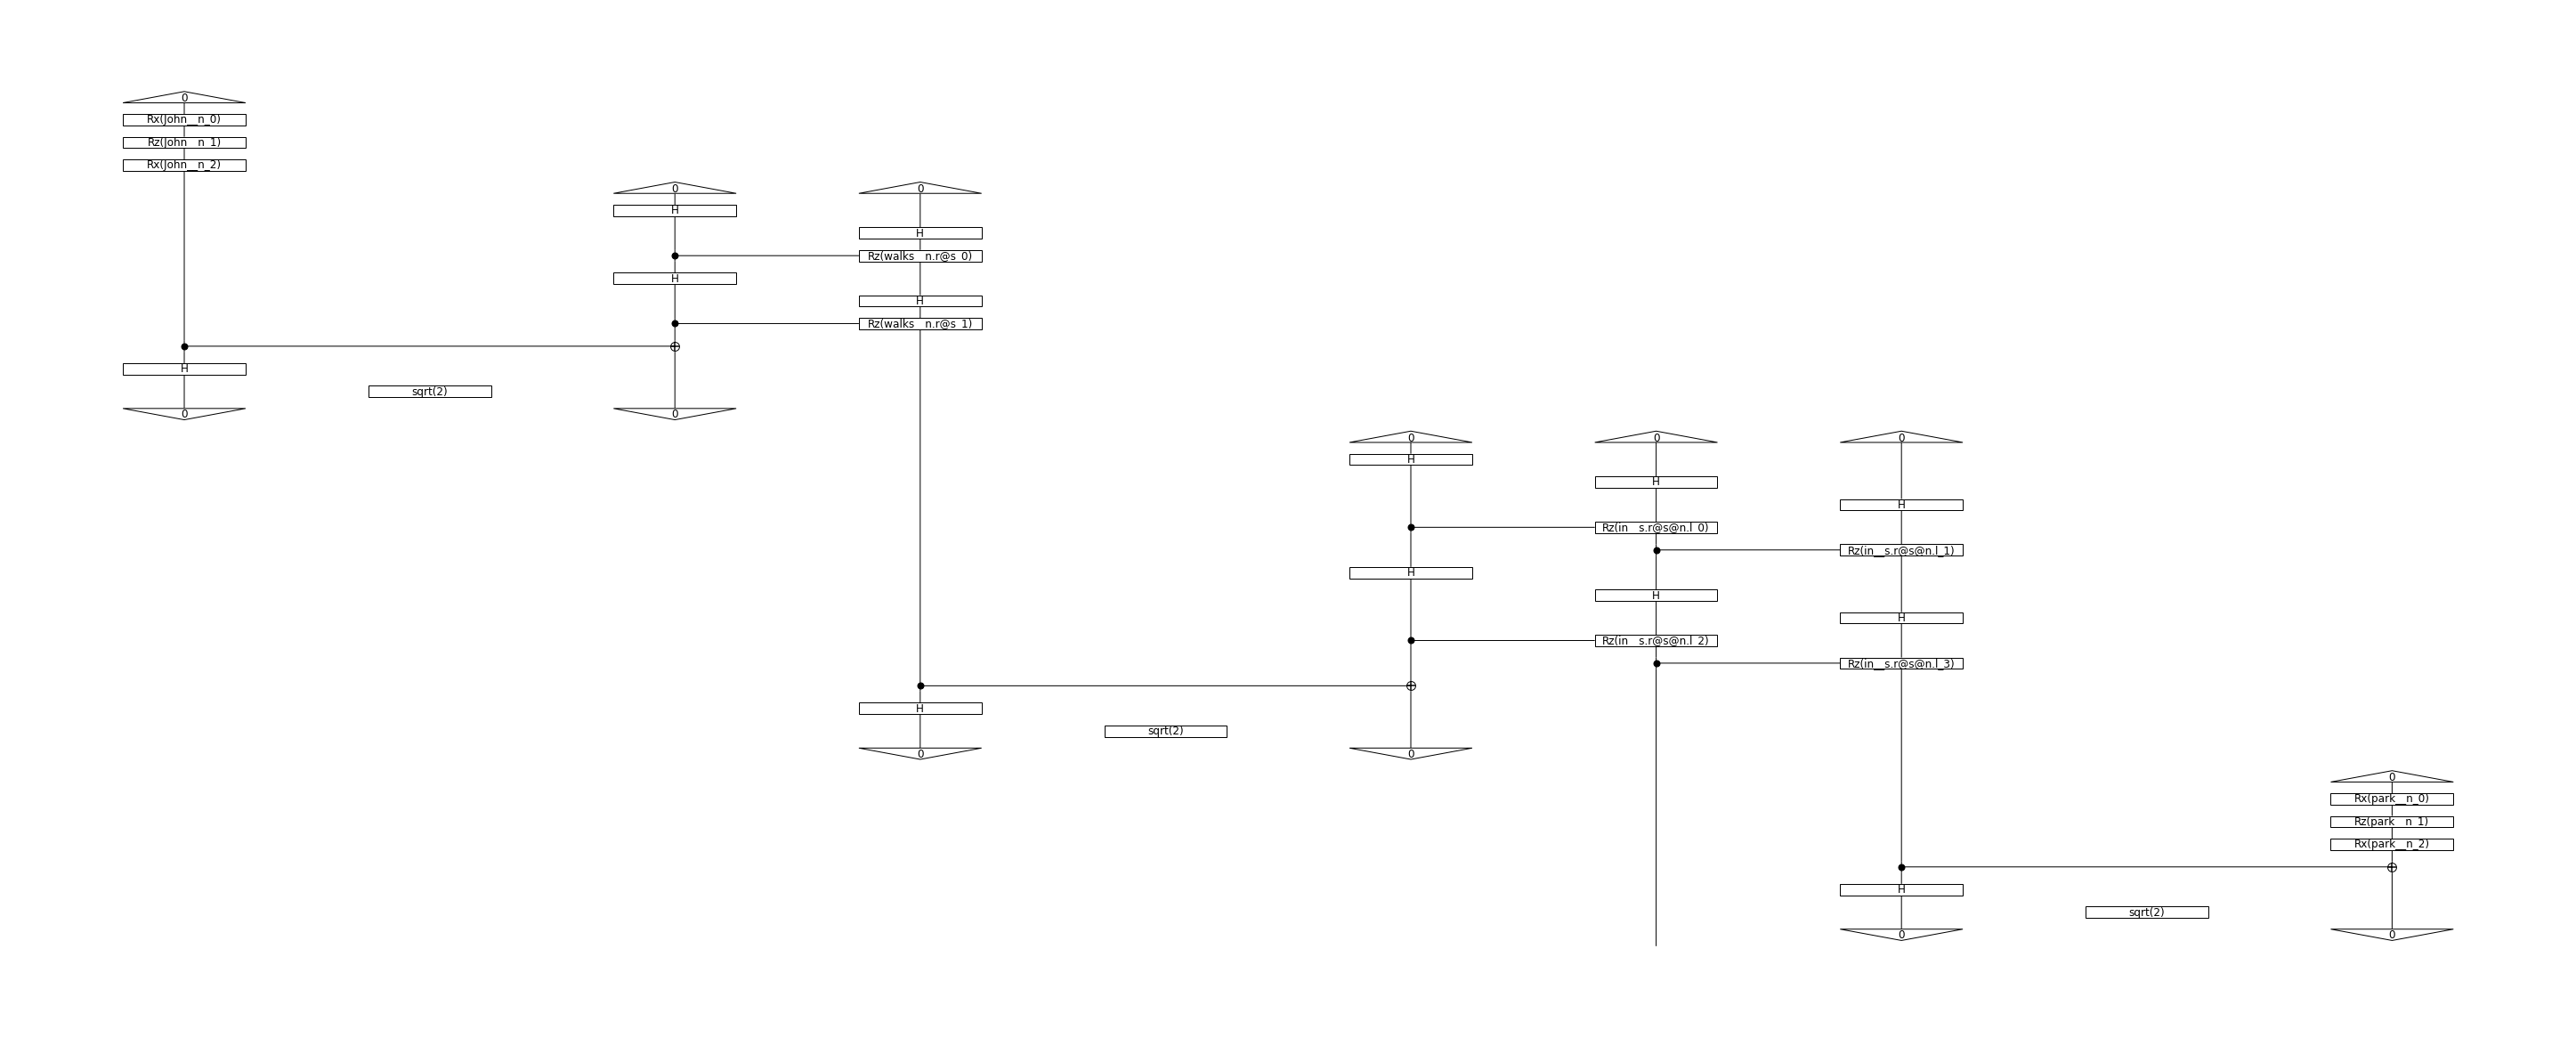

In [30]:
# Convert string diagram to qc - 1 qubit per atomic type
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
discopy_circuit = ansatz(normalized_diagram)
discopy_circuit.draw(figsize=(40, 16), fontsize=12)

In [20]:
# Convert qc from DisCoPy to pytket format
from pytket.circuit.display import render_circuit_jupyter

In [21]:
tket_circuit = discopy_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

### Training: Quantum case

In [13]:
BATCH_SIZE = 30
EPOCHS = 1

In [14]:
df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


Inspecting `grammar.json`:

In [16]:
import json

In [17]:
grammar_json_path = "/home/jovyan/.cache/lambeq/bobcat/bert/grammar.json"

In [18]:
with open(grammar_json_path, "r") as f:
    grammar_json = json.load(f)

Based on the sentence structures, we have the following grammatical structures. This might be important later.
- Noun
- Noun phrase
- Sentence
- Verb (transitive)
- Adjective

In [15]:
df.shape

(100, 3)

In [16]:
df[df["label"] == 1].shape

(53, 3)

In [17]:
from sklearn.model_selection import train_test_split, RepeatedKFold

In [18]:
df_train_val, df_test = train_test_split(df, test_size=0.2, shuffle=True)

In [19]:
df_train_val.shape

(80, 3)

In [20]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5)

In [21]:
rkf_splits = list(rkf.split(df_train_val))

In [22]:
parser = BobcatParser()

In [41]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

In [23]:
train_idx, val_idx = rkf_splits[0]
df_train, df_val = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]

In [51]:
def preprocess_df(df):
    # Create raw diagram for both datasets.
    # We require both sentences to have a diagram
    # so it can be part of the dataset.
    df["s1_diagram"] = parser.sentences2diagrams(list(df["s1"].values), suppress_exceptions=True)
    df["s2_diagram"] = parser.sentences2diagrams(list(df["s2"].values), suppress_exceptions=True)
    df.dropna(inplace=True)

    # Convert to normal form
    df["s1_diagram"] = df["s1_diagram"].apply(lambda d: d.normal_form())
    df["s2_diagram"] = df["s2_diagram"].apply(lambda d: d.normal_form())

    # Vectorize label
    df["label_v"] = df["label"].apply(lambda l: [1, 0] if l == 0 else [0, 1])

    # Create circuits
    df["s1_circuit"] = df["s1_diagram"].apply(lambda d: ansatz(remove_cups(d)))
    df["s2_circuit"] = df["s2_diagram"].apply(lambda d: ansatz(remove_cups(d)))

In [52]:
preprocess_df(df_train)

Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

In [53]:
df_train.head()

,s1,s2,label,s1_diagram,s2_diagram,label_v,s1_circuit,s2_circuit
40,hacker creates code,skilful chef creates meal,0,"(((hacker)), ((Id(n) @ creates)), ((Cup(n, n.r...","(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","[1, 0]","(((Ket(0, 0, 0))), ((H @ Id(2))), ((Id(1) @ H ...","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ..."
80,devoted hacker creates complicated code,skilful cook prepares complicated meal,0,"(((devoted)), ((Id(n) @ creates @ Id(n.l))), (...","(((skilful)), ((Id(n) @ prepares @ Id(n.l))), ...","[1, 0]","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ...","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ..."
7,devoted programmer creates advanced code,skilful programmer writes advanced code,1,"(((devoted)), ((Id(n) @ creates @ Id(n.l))), (...","(((skilful)), ((Id(n) @ writes @ Id(n.l))), ((...","[0, 1]","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ...","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ..."
76,devoted hacker writes complicated code,skilful chef creates dish,0,"(((devoted)), ((Id(n) @ writes @ Id(n.l))), ((...","(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","[1, 0]","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ...","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ..."
79,skilful programmer creates complicated code,chef creates meal,0,"(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","(((chef)), ((Id(n) @ creates)), ((Cup(n, n.r) ...","[1, 0]","(((Ket(0, 0))), ((H @ Id(1))), ((Id(1) @ H)), ...","(((Ket(0, 0, 0))), ((H @ Id(2))), ((Id(1) @ H ..."


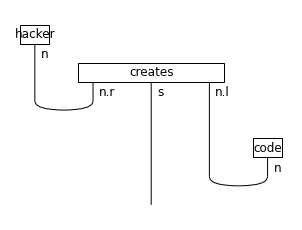

In [54]:
df_train["s1_diagram"][40].draw(figsize=(4, 3), fontsize=12)

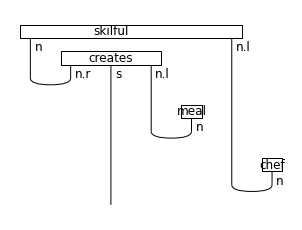

In [55]:
df_train["s2_diagram"][40].draw(figsize=(4, 3), fontsize=12)

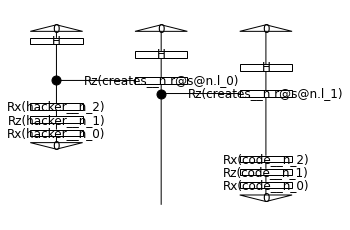

In [56]:
df_train["s1_circuit"][40].draw(figsize=(4, 3), fontsize=12)

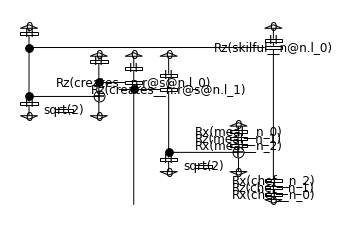

In [57]:
df_train["s2_circuit"][40].draw(figsize=(4, 3), fontsize=12)

In [58]:
preprocess_df(df_val)

Tagging sentences:   0%|          | 0/4 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/16 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/4 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/16 [00:00<?, ?it/s]

In [64]:
all_circuits = (list(df_train["s1_circuit"].values) + list(df_train["s2_circuit"].values) +
                list(df_val["s1_circuit"].values) + list(df_val["s2_circuit"].values))

In [65]:
backend = AerBackend()
backend_config = {
    "backend": backend,
    "compilation": backend.default_compilation_pass(2),
    "shots": 8192,
}

In [66]:
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [67]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
eval_metrics = {"acc": acc}